#Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports Dependencies
We will use TensorFlow, a framework designed for creating and training machine learning models, including deep neural networks.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from PIL import ImageEnhance, ImageOps

import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Input
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

#Set path
1. In training_images_path there are 800 images belonging to the DIV2K dataset with which we are going to do the GAN training
2. In testing_images_path there are 100 images belonging to the DIV2K dataset with which we are going to create upscaled images generated by the trained generator and measure the accuracy of the model
3. In res_im_path will be loaded the images generated by the model either in the training phase or in the generation phase
4. In models_path the discriminator and generator models created by the gan training will be loaded (we will only need the generator model)

In [ ]:
training_images_path = "/content/drive/My Drive/SRGAN/training/"
testing_images_path = "/content/drive/My Drive/SRGAN/testing/"
res_im_path = "/content/drive/My Drive/SRGAN/results/"
models_path = "/content/drive/My Drive/SRGAN/models/"

#Generator
A convolutional neural network (CNN) that takes as input a three-dimensional tensor, in this case a 64x64 RGB image, and returns a generated output tensor, i.e. a 256x256 RGB image. A 4x upscaling is performed in this generator.


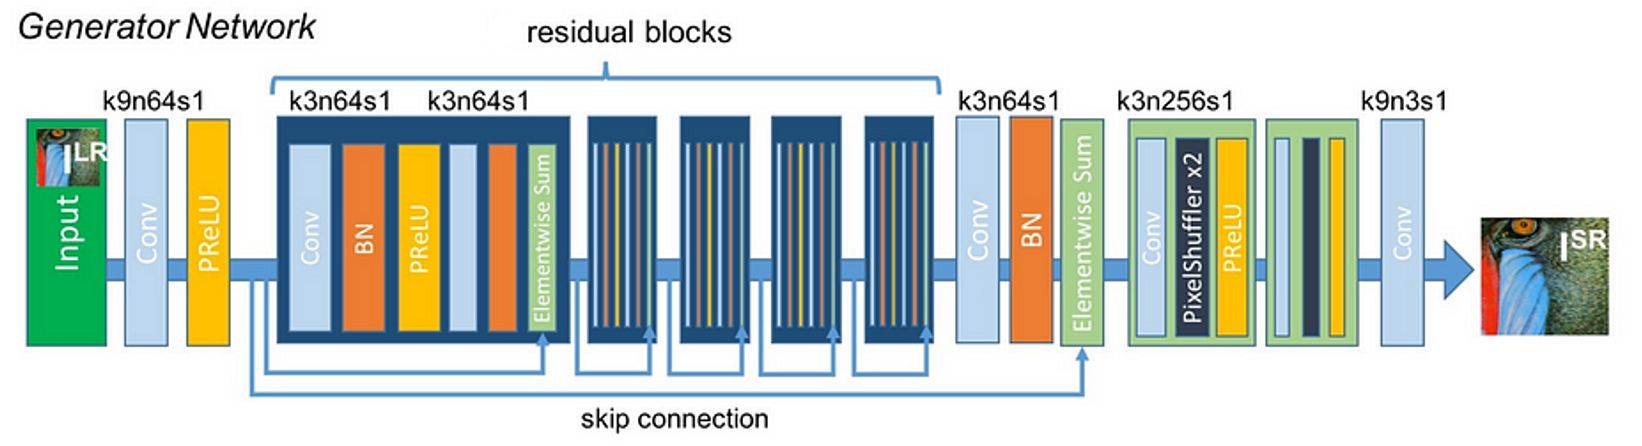

In [ ]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Add()([res, x])

    return res

def build_generator():

    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)
    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

#Discriminator
A convolutional neural network (CNN) that takes as input a three-dimensional tensor, in this case a 256x256 RGB image, and returns a single value, representing the probability that the input image is real or created by the generator.

Initially, the first convolutional layers detect low-level features such as simple edges and colours, while as one moves to the next layers, the features extracted become more abstract and sophisticated, such as shapes and textures.

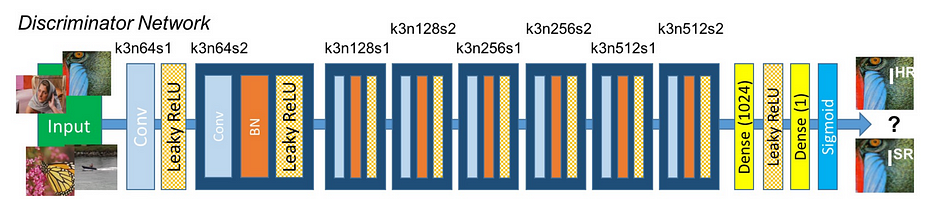

In [ ]:
def build_discriminator():

    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)
    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)
    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)
    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)
    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)
    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)
    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)
    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)
    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

#Feature Extractor - VGG19 Model
A pre-trained model on the ImageNet dataset for image feature extraction

In [ ]:
def build_vgg():

    input_shape = (256, 256, 3)

    vgg = keras.applications.VGG19(include_top = False ,  input_shape = input_shape , weights="imagenet")
    features = vgg.get_layer(index = 9).output

    model = keras.Model(inputs=[vgg.inputs], outputs=[features])
    return model

#Input for the model
It creates a stream of high and low-resolution images to which transformations related to rotation, zoom, and brightness are randomly applied to have a given augmentation and thus train a more efficient model.

In [ ]:
def input_pipeline(data_path , batch_size , highres_shape , lowres_shape):

  all_images = glob.glob(data_path + "*")
  cntall = len(all_images)

  def gen():
    while True:

      all_highres = []
      all_lowres = []

      idxes = np.random.choice(cntall , batch_size , replace = False)
      for idx in idxes:

        fname = all_images[idx]

        orig = Image.open(fname)

        # Data augmentation
        if np.random.random() < 0.5:
          # Adjust brightness
          enhancer = ImageEnhance.Brightness(orig)
          orig = enhancer.enhance(np.random.uniform(0.7, 1.3))

        if np.random.random() < 0.5:
          # Rotate image
          orig = orig.rotate(np.random.uniform(-15, 15))

        if np.random.random() < 0.5:
          # Zoom image
          x_center = orig.width / 2
          y_center = orig.height / 2
          width = orig.width * np.random.uniform(0.9, 1.1)
          height = orig.height * np.random.uniform(0.9, 1.1)
          left = x_center - width / 2
          top = y_center - height / 2
          right = x_center + width / 2
          bottom = y_center + height / 2
          orig = orig.crop((left, top, right, bottom))

        high_img = orig.resize(highres_shape , resample=Image.BICUBIC)
        low_img = orig.resize(lowres_shape , resample=Image.BICUBIC)

        if np.random.random() < 0.5:
          high_img = ImageOps.mirror(high_img)
          low_img = ImageOps.mirror(low_img)

        all_highres.append(np.asarray(high_img , dtype = np.float32))
        all_lowres.append(np.asarray(low_img , dtype = np.float32))

        high_res_ret = np.array(all_highres)/127.5 - 1
        low_res_ret = np.array(all_lowres)/127.5 - 1

      yield (high_res_ret , low_res_ret)

  return tf.data.Dataset.from_generator(gen , (tf.float32 , tf.float32)).prefetch(5)


#Image Saving
To display and save:
1.   low-resolution
2.   high-resolution generated image
3.   original high-resolution image



In [ ]:
def save_images(data_path , lowres , highres , orig):
  lowres = np.squeeze( (lowres.numpy() + 1)/2.0 )
  highres = np.squeeze( (highres + 1)/2.0 )
  orig = np.squeeze( (orig.numpy() + 1)/2.0 )

  fig = plt.figure(figsize=(12 , 4))

  ax = fig.add_subplot(1, 3, 1)
  ax.imshow(lowres)
  ax.axis("off")
  ax.set_title("Low-resolution")

  ax = fig.add_subplot(1, 3, 2)
  ax.imshow(orig)
  ax.axis("off")
  ax.set_title("Original")

  ax = fig.add_subplot(1, 3, 3)
  ax.imshow(highres)
  ax.axis("off")
  ax.set_title("Generated")

  plt.savefig(data_path)

#Model Definition
1. Training parameters such as mode ('train', 'evaluate' or 'generate'), number of training epochs, batch size and Adam optimiser are initialised.
2. VGG19 and discriminator networks with mean squared error loss functions and Adam optimiser are built and compiled.
3. The generating network is built.
4. The adversary model combining the generator, VGG19 and the discriminator is built and then compiled with two different loss functions (binary crossentropy and mse) and their respective loss weights, using Adam optimiser.



In [ ]:
#Parameters of Training
mode = 'generate'
epochs = 5
batch_size = 1
common_optimizer = Adam(0.0002, 0.5)
low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

# Build and compile the VGG19
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

#Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

# Build the generator network
generator = build_generator()

"""Build and compile the adversarial model"""

# Input layers for high-resolution and low-resolution images
input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)

# Generate high-resolution images from low-resolution images
generated_high_resolution_images = generator(input_low_resolution)

# Extract feature maps of the generated images
features = vgg(generated_high_resolution_images)

# Get the probability of generated high-resolution images
probs = discriminator(generated_high_resolution_images)

# Create an adversarial model
adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])

# Get the list of trainable variables
variables = adversarial_model.trainable_variables

# Build the optimizer with the list of trainable variables
common_optimizer.build(variables)

# Compile the adversarial model
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)


#Training
If the mode is ‘train’, both the discriminator and the generator are trained in each epoch.

1. The discriminator is trained on a batch of real images and a batch of images generated by the generator. Losses for both cases are calculated and then combined to obtain the discriminator's total loss.

2. The generator is then trained. A batch of low-resolution images and corresponding high-resolution images is provided. The high-resolution images are used to extract features using VGG19. Then, the loss of the generator is calculated using both the real labels and the extracted features. This loss is passed to the opponent model for training.

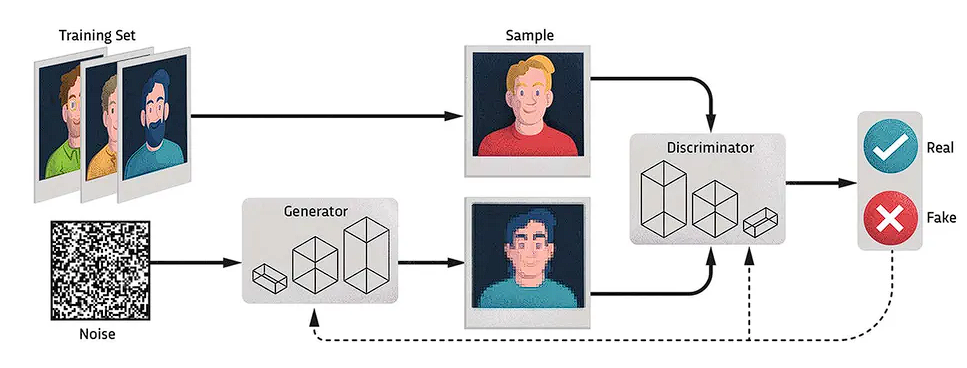

1/1 [==============================] - 1s 667ms/step
Epoch 1 : g_loss: 92.083984375 , d_loss: 0.31876078248023987
1/1 [==============================] - 1s 1s/step
Epoch 2 : g_loss: 107.757080078125 , d_loss: 0.30500084161758423
1/1 [==============================] - 1s 863ms/step
Epoch 3 : g_loss: 60.674766540527344 , d_loss: 0.27025584876537323
1/1 [==============================] - 1s 601ms/step
Epoch 4 : g_loss: 59.69472885131836 , d_loss: 0.2477143332362175
1/1 [==============================] - 1s 578ms/step
Epoch 5 : g_loss: 90.96797943115234 , d_loss: 0.25601548701524734


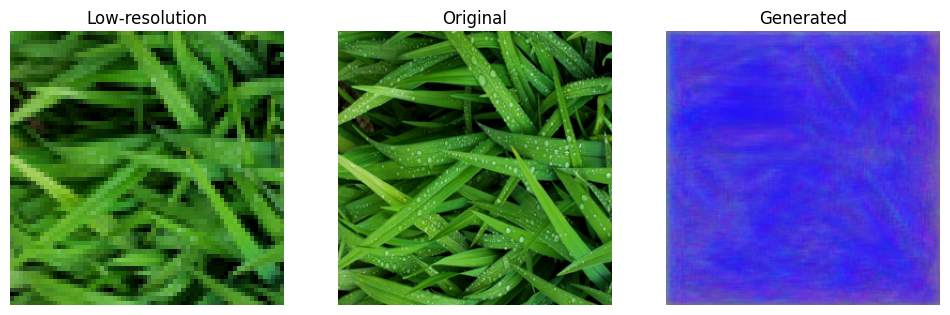

In [ ]:
if mode == 'train':

  def just_train():

      dataloader = iter(input_pipeline(training_images_path , batch_size , high_resolution_shape[:2] , low_resolution_shape[:2]))

      for epoch in range(epochs):

        """Train the discriminator network"""

        # Sample a batch of images
        high_resolution_images, low_resolution_images = next(dataloader)

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator.predict(low_resolution_images)

        # Generate batch of real and fake labels
        real_labels = np.ones((batch_size, 16, 16, 1))
        fake_labels = np.zeros((batch_size, 16, 16, 1))

        # Train the discriminator network on real and fake images
        d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)

        d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)


        # Calculate total discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        """Train the generator network"""

        # Sample a batch of images
        high_resolution_images, low_resolution_images = next(dataloader)

        # Extract feature maps for real high-resolution images
        image_features = vgg.predict(high_resolution_images)

        # Train the generator network
        g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],[real_labels, image_features])

        print("Epoch {} : g_loss: {} , d_loss: {}".format(epoch+1 , g_loss[0] , d_loss[0]))

        # Save image of first epoch
        if (epoch+1) == 1:
            high_resolution_images, low_resolution_images = next(dataloader)

            # Normalize image
            generated_images = generator.predict_on_batch(low_resolution_images)

            for index, img in enumerate(generated_images):
                save_images(res_im_path + "img_{}_{}".format(epoch+1, index),low_resolution_images[index], generated_images[index] , high_resolution_images[index])

        # Sample and save images after every 100 epochs
        if (epoch+1) % 100 == 0:
            high_resolution_images, low_resolution_images = next(dataloader)

            # Normalize images
            generated_images = generator.predict_on_batch(low_resolution_images)

            for index, img in enumerate(generated_images):
                save_images(res_im_path + "img_{}_{}".format(epoch+1, index),low_resolution_images[index], generated_images[index] , high_resolution_images[index])

            # Save models
            generator.save_weights(models_path+"generator_{}.h5".format(epoch+1))
            discriminator.save_weights(models_path+"discriminator_{}.h5".format(epoch+1))

  just_train()


#Evaluation
If the mode is ‘evaluate’, error metrics for PSNR (Peak Signal-to-Noise Ratio) and MSE (Mean Squared Error) are evaluated. These metrics compare the generated image with the original high-resolution image.
1. PSNR (Peak Signal-to-Noise Ratio): This metric measures the ratio between the maximum power of a signal (in this case, the original image) and the power of the noise corrupting the signal (in this case, the difference between the original and the generated image). A higher PSNR value indicates better image quality because it suggests that the generated image is closer to the original.
2. MSE (Mean Squared Error): This metric calculates the mean square error between the original image and the generated image. Each pixel of the generated image is compared with the corresponding pixel of the original image and the difference is squared. These values are then averaged over all pixels. A lower MSE value indicates better image quality because it suggests that the generated image is closer to the original.

PSNR: 20.215098028401925, MSE: 0.03806713466826456
Average PSNR: 20.895066551794393, Average MSE: 0.03497796307994137


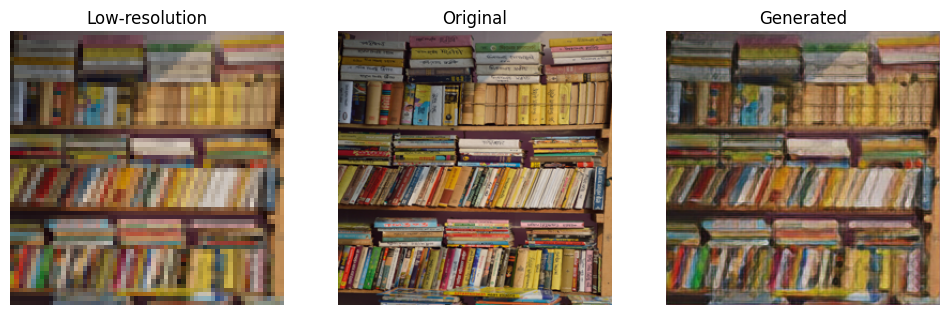

In [ ]:
if mode == "evaluate":

  generator.load_weights(os.path.join(models_path , "generator_9700.h5"))

  dataloader = iter(input_pipeline(testing_images_path , batch_size , high_resolution_shape[:2] , low_resolution_shape[:2]))

  for i in range(1):
    high_resolution_images, low_resolution_images = next(dataloader)
    generated_images = generator.predict_on_batch(low_resolution_images)
    save_images("/content/drive/MyDrive/SRGAN/results/" + "img{}.jpeg".format(i), low_resolution_images[0], generated_images[0] , high_resolution_images[0])

    psnr_value = psnr(np.array(high_resolution_images), np.array(generated_images))
    mse_value = mse(np.array(high_resolution_images), np.array(generated_images))

    print(f"PSNR: {psnr_value}, MSE: {mse_value}")


  psnr_total = 0
  mse_total = 0
  num_images = 20

  for i in range(num_images):
      high_resolution_images, low_resolution_images = next(dataloader)
      generated_images = generator.predict_on_batch(low_resolution_images)

      psnr_value = psnr(np.array(high_resolution_images), np.array(generated_images))
      mse_value = mse(np.array(high_resolution_images), np.array(generated_images))

      psnr_total += psnr_value
      mse_total += mse_value

  psnr_average = psnr_total / num_images
  mse_average = mse_total / num_images

  print(f"Average PSNR: {psnr_average}, Average MSE: {mse_average}")


#Generation - Decomposition and Recomposition
To implement the model in images larger than 64x64 and not square we will carry out a ‘decomposition and recomposition’ technique:
1. If the image is not square we will apply edge padding
2. We divide the selected image into many small 48x48 square patches.
3. We apply edge padding for each 48x48 square patch to create a 64x64 square patch (the generator can only work on 64x64 images)
4. The patches are upscaled
5. The upscaled patches are crop out and brought back to 48x48
6. The upscaled image is recomposed and the padding is cropped

If we used 64x64 images directly, because the trained model creates a slightly darker frame on the edge, at the end of the assembly process, we would have an image with a “tessellated” effect.

Original Dimensions: 225x225
Upscaled Dimensions: 900x900
1/1 [==============================] - 2s 2s/step


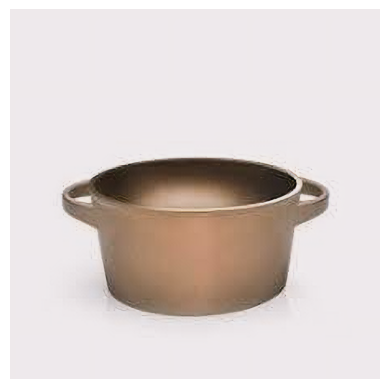

In [ ]:
if mode == "generate":

  generator.load_weights(os.path.join(models_path , "generator_9700.h5"))

  def divide_image(input_image_path):
      image = Image.open(input_image_path).convert('RGB')
      width, height = image.size
      print(f"Original Dimensions: {width}x{height}")
      print(f"Upscaled Dimensions: {width*4}x{height*4}")

      # Calculate dimensions with padding
      padded_width = (width + 47) // 48 * 48
      padded_height = (height + 47) // 48 * 48
      padding_pixels_width = padded_width - width
      padding_pixels_height = padded_height - height

      # Create a new image with reflection padding
      padded_image_array = np.pad(image, ((0, padding_pixels_height), (0, padding_pixels_width), (0, 0)), mode='edge')
      padded_image = Image.fromarray(padded_image_array)


      # Divides the image into 62x62 batches and applies upscaling
      pieces = []
      for i in range(0, padded_height, 48):
          for j in range(0, padded_width, 48):
              box = (j, i, j+48, i+48)
              piece = padded_image.crop(box)
              piece = np.pad(piece, ((8, 8), (8, 8), (0, 0)), mode='edge')
              upscaled_piece = np.asarray(piece, dtype=np.float32) / 127.5 - 1
              upscaled_piece = generator.predict(np.expand_dims(upscaled_piece, axis=0))
              upscaled_piece = np.squeeze(upscaled_piece, axis=0)
              upscaled_piece = Image.fromarray(((upscaled_piece + 1) * 127.5).astype('uint8'))
              upscaled_piece = upscaled_piece.crop((32, 32, 224, 224))
              upscaled_piece = np.asarray(upscaled_piece, dtype=np.float32) / 127.5 - 1


              pieces.append(upscaled_piece)



      return pieces, width, height


  def reassemble_images(pieces, original_width, original_height):
      # Calculates the size of the final image
      image_width = pieces[0].shape[1]
      image_height = pieces[0].shape[0]
      num_images = len(pieces)
      num_images_per_row = (original_width + 47) // 48
      total_width = image_width * num_images_per_row
      total_height = image_height * (num_images // num_images_per_row)

      # Create a new image to contain all images
      new_image = Image.new('RGB', (total_width, total_height))

      # Paste each image in the right place
      for index, piece in enumerate(pieces):
          x = (index % num_images_per_row) * image_width
          y = (index // num_images_per_row) * image_height
          piece = Image.fromarray(((piece + 1) * 127.5).astype('uint8'))
          new_image.paste(piece, (x, y))

      # Removes padding
      new_image = new_image.crop((0, 0, original_width*4, original_height*4))

      # shows the final image
      plt.imshow(new_image)
      plt.axis('off')
      plt.show()


  pieces, original_width, original_height = divide_image("/content/drive/MyDrive/SRGAN/images.jpg")
  reassemble_images(pieces, original_width, original_height)